In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

path = '/userhome/34/ybyan/pytorchForecasting'
#print(os.path)

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

load data from github

In [3]:
data = pd.read_csv(path + '/result.csv', index_col = False)

#print(data.index.stop)
#print(data.columns.values)
data["time_idx"] = data.index
data["group"] = 0
#data.sort_values(by = ['Date'], inplace = True)

size = data.index.stop - 365 * 9.4
data = data[lambda x: x.time_idx >= size]
data['time_idx'] -= data["time_idx"].min()

print(data)

            Date  ave_block_size    difficulty     hash_rate  market_price  \
1459  2012-12-31        0.074741  2.979637e+06  2.488391e+01        13.570   
1460  2013-01-01        0.105148  2.979637e+06  2.310649e+01        13.400   
1461  2013-01-02        0.114158  2.979637e+06  2.369897e+01        13.464   
1462  2013-01-03        0.150549  2.979637e+06  2.369897e+01        13.420   
1463  2013-01-04        0.105734  2.979637e+06  2.206966e+01        13.548   
...          ...             ...           ...           ...           ...   
4885  2022-05-19        1.335490  3.125110e+13  1.895271e+08     28680.970   
4886  2022-05-20        1.443017  3.125110e+13  1.988481e+08     30289.870   
4887  2022-05-21        1.071193  3.125110e+13  2.097226e+08     29159.500   
4888  2022-05-22        1.205589  3.125110e+13  1.895271e+08     29409.920   
4889  2022-05-23        1.142381  3.125110e+13  2.485601e+08     30278.940   

        miners_rev  transaction  ex_trage_vol  time_idx  group 

In [13]:
# create the dataset from the pandas dataframe
# pre = 6, encoder = 30, cutoff-120 : error out of idx size
max_prediction_length = 7
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    group_ids=["group"],
    target="market_price",
    time_idx="time_idx",
    add_relative_time_idx=True, # without this item, the error will occur in lr_find
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['ave_block_size', 'difficulty', 'hash_rate', 'market_price','miners_rev', 'transaction', 'ex_trage_vol']
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Create baseline model

In [14]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1554.5755615234375

Train the Temporal Fusion Transformer Find optimal learning rate

In [15]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    default_root_dir = path
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /userhome/34/ybyan/pytorchForecasting/.lr_find_0d7338c6-8855-4c11-a64f-40218c66f522.ckpt


suggested learning rate: 0.0019498445997580445


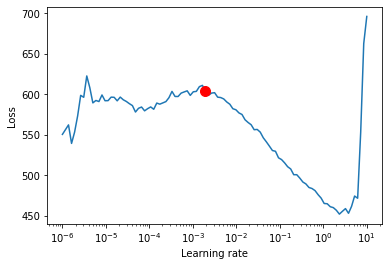

In [16]:
#print(trainer)
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [17]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(path + "/lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    enable_model_summary=False,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0019498445997580445,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


In [18]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path=path + "/optuna_test",
    log_dir = path + '/lightning_logs',
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

import pickle
# save study results - also we can resume tuning at a later point in time
with open(path + "/test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2022-05-26 14:01:39,633] A new study created in memory with name: no-name-111ff88d-1679-4baf-ba86-ebedc39ccf46
/userhome/34/ybyan/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-05-26 14:06:06,606] Trial 0 finished with value: 572.1329956054688 and parameters: {'gradient_clip_val': 0.033690952007490185, 'hidden_size': 27, 'dropout': 0.17690359164009584, 'hidden_continuous_size': 23, 'attention_head_size': 1, 'learning_rate': 0.005814390191285607}. Best is trial 0 with value: 572.1329956054688.
/userhome/34/ybyan/anaconda3/lib/python3.8/sit

{'gradient_clip_val': 0.4632797587278457, 'hidden_size': 107, 'dropout': 0.22021672967010855, 'hidden_continuous_size': 45, 'attention_head_size': 1, 'learning_rate': 0.038299235199982795}


Evaluate performance

In [20]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/userhome/34/ybyan/pytorchForecasting/lightning_logs/lightning_logs/version_6/checkpoints/epoch=29-step=900.ckpt


tensor(924.0059)


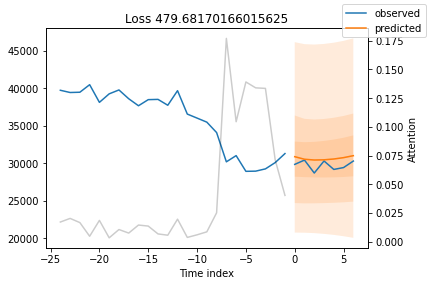

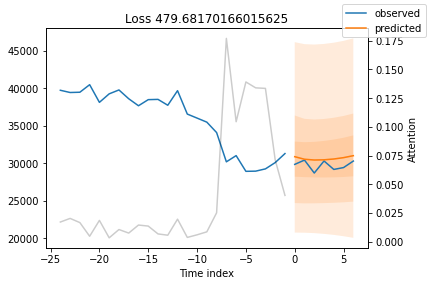

In [25]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
ave_loss = (actuals - predictions).abs().mean()
print(ave_loss)

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
#for idx in range(10):  # plot 10 examples
    


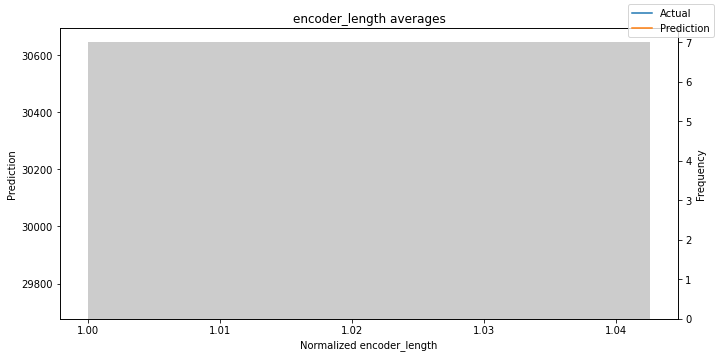

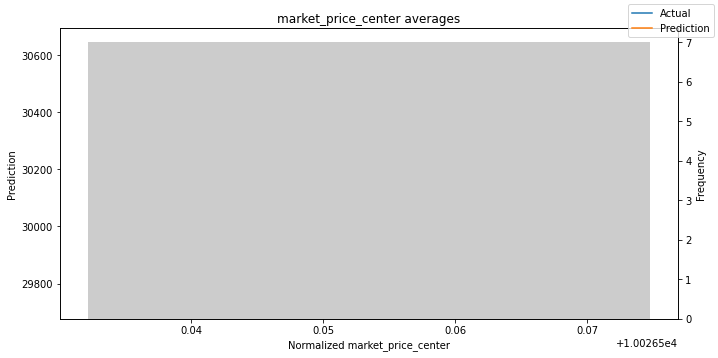

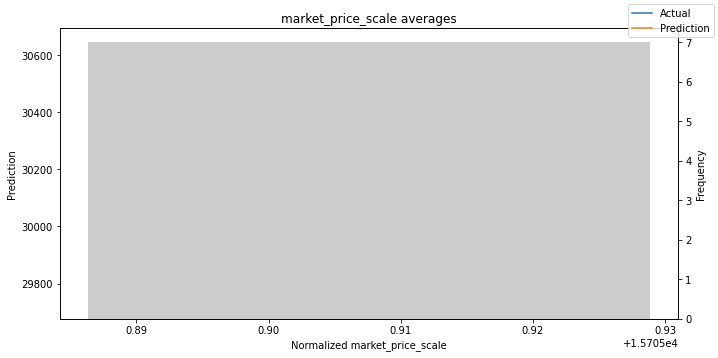

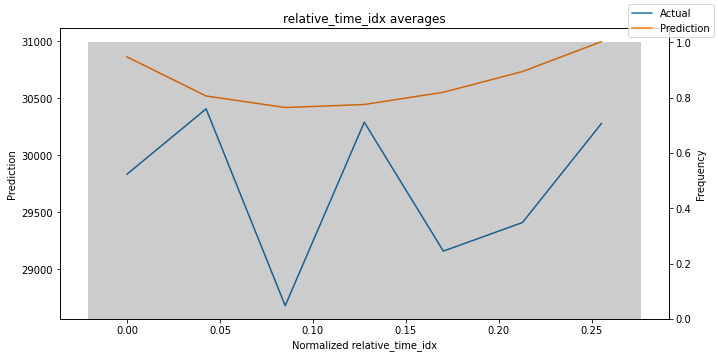

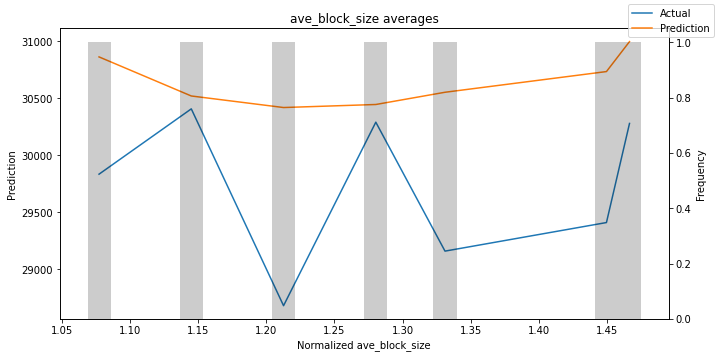

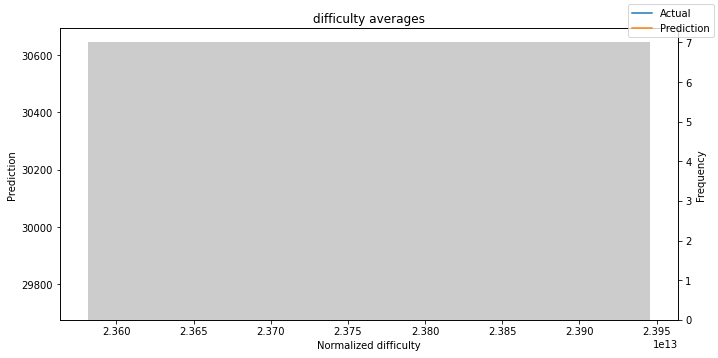

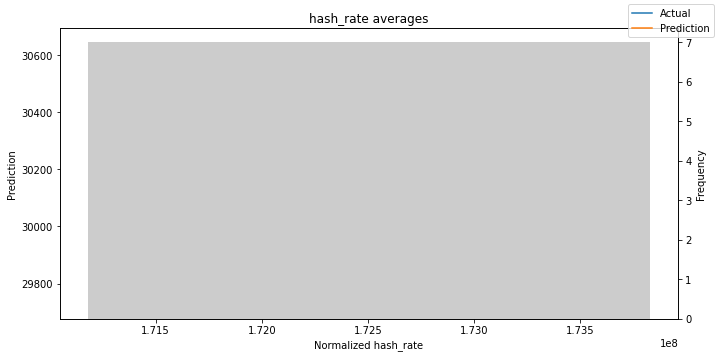

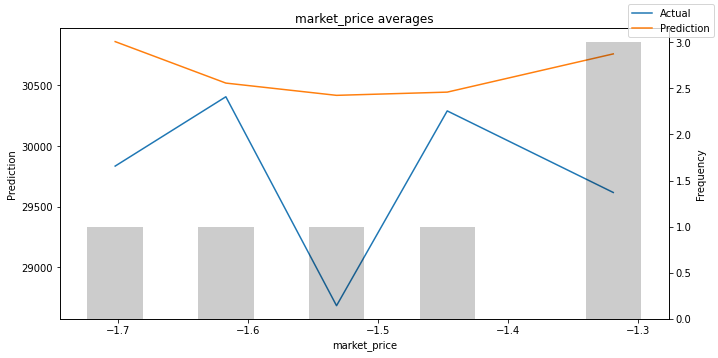

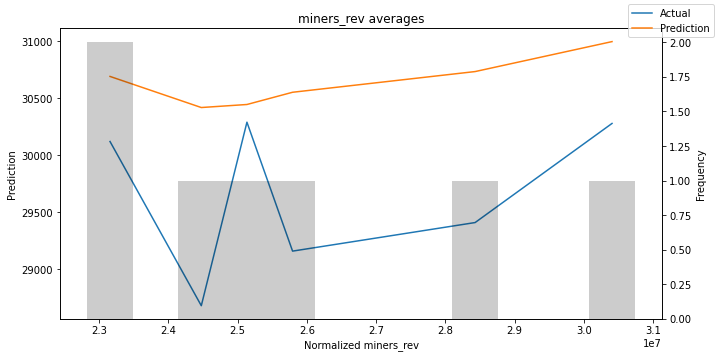

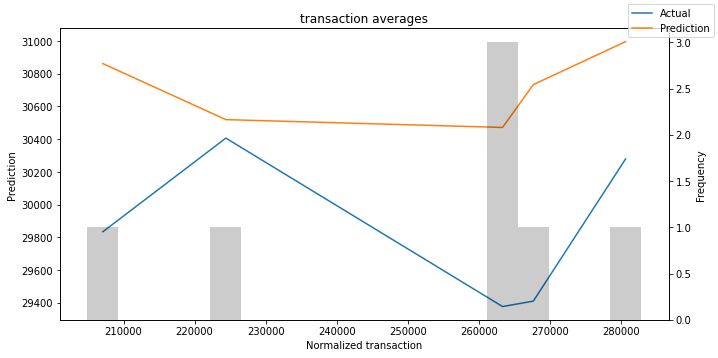

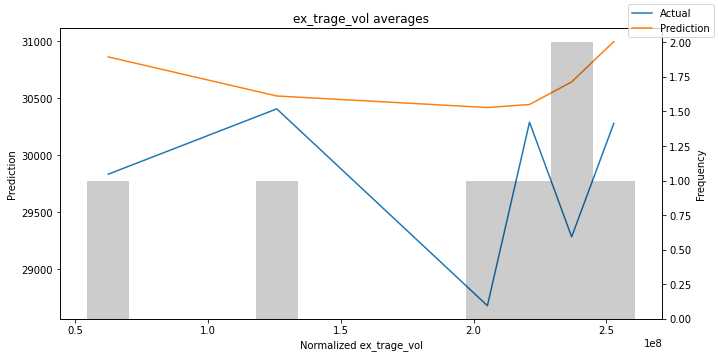

In [26]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [28]:
# create the dataset from the pandas dataframe
# pre = 6, encoder = 30, cutoff-120 : error out of idx size
max_prediction_length = 3
max_encoder_length = 14
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    group_ids=["group"],
    target="market_price",
    time_idx="time_idx",
    add_relative_time_idx=True, # without this item, the error will occur in lr_find
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['ave_block_size', 'difficulty', 'hash_rate', 'market_price','miners_rev', 'transaction', 'ex_trage_vol']
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

base model

In [29]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

673.7493286132812

In [30]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    default_root_dir = path
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /userhome/34/ybyan/pytorchForecasting/.lr_find_ccc674a2-c853-4368-a9ee-0a5b04f0e2b2.ckpt


suggested learning rate: 0.013489628825916528


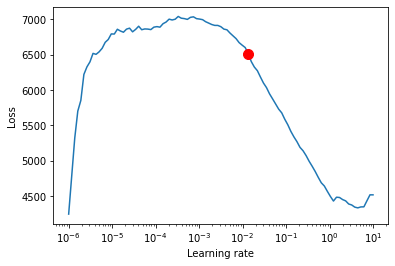

In [31]:
#print(trainer)
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [32]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(path + "/lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    enable_model_summary=False,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 0.013489628825916528,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


In [33]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path=path + "/optuna_test",
    log_dir = path + '/lightning_logs',
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

import pickle
# save study results - also we can resume tuning at a later point in time
with open(path + "/test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-26 16:36:33,895] A new study created in memory with name: no-name-11eceb4e-aa0e-4861-ba5e-2f6fdaeb0ace
/userhome/34/ybyan/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-05-26 16:39:20,357] Trial 0 finished with value: 1357.9427490234375 and parameters: {'gradient_clip_val': 0.11943093655492971, 'hidden_size': 26, 'dropout': 0.28455008142743055, 'hidden_continuous_size': 26, 'attention_head_size': 3, 'learning_rate': 0.008135504445124172}. Best is trial 0 with value: 1357.9427490234375.
/userhome/34/ybyan/anaconda3/lib/python3.8/si

{'gradient_clip_val': 0.18172385153442797, 'hidden_size': 68, 'dropout': 0.10478069300986782, 'hidden_continuous_size': 61, 'attention_head_size': 3, 'learning_rate': 0.009916890189222252}


/userhome/34/ybyan/pytorchForecasting/lightning_logs/lightning_logs/version_7/checkpoints/epoch=29-step=900.ckpt
tensor(2589.0872)


{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'market_price_center': <Figure size 720x360 with 2 Axes>,
 'market_price_scale': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'ave_block_size': <Figure size 720x360 with 2 Axes>,
 'difficulty': <Figure size 720x360 with 2 Axes>,
 'hash_rate': <Figure size 720x360 with 2 Axes>,
 'market_price': <Figure size 720x360 with 2 Axes>,
 'miners_rev': <Figure size 720x360 with 2 Axes>,
 'transaction': <Figure size 720x360 with 2 Axes>,
 'ex_trage_vol': <Figure size 720x360 with 2 Axes>}

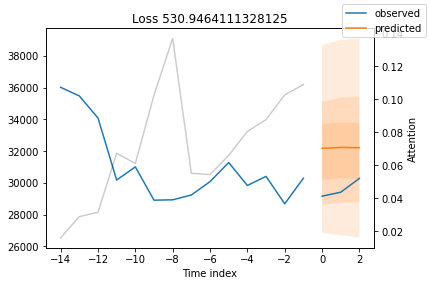

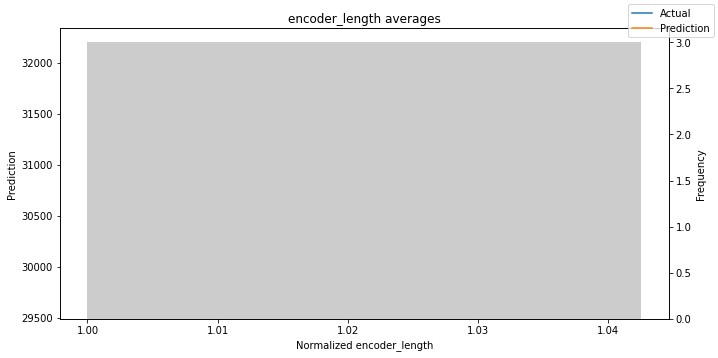

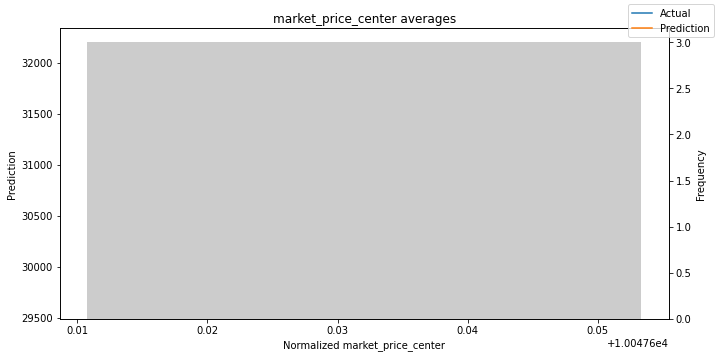

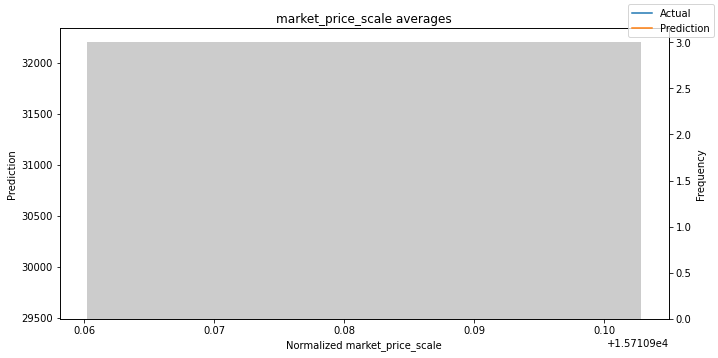

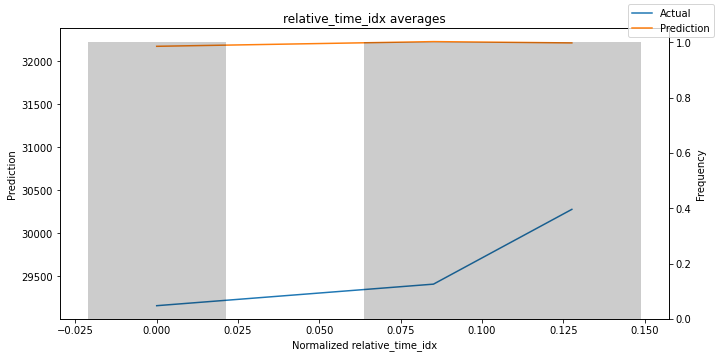

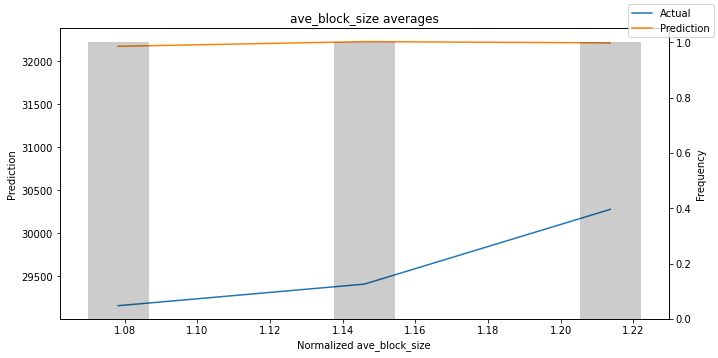

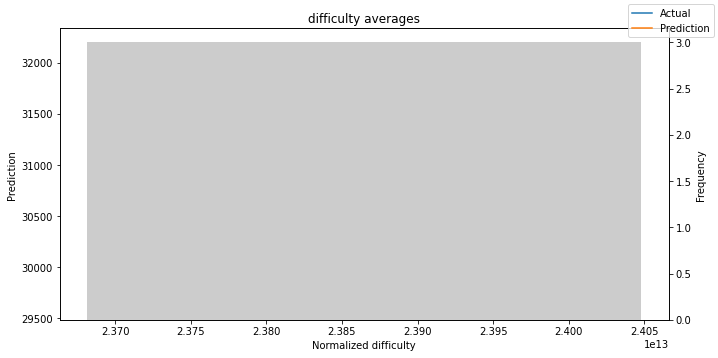

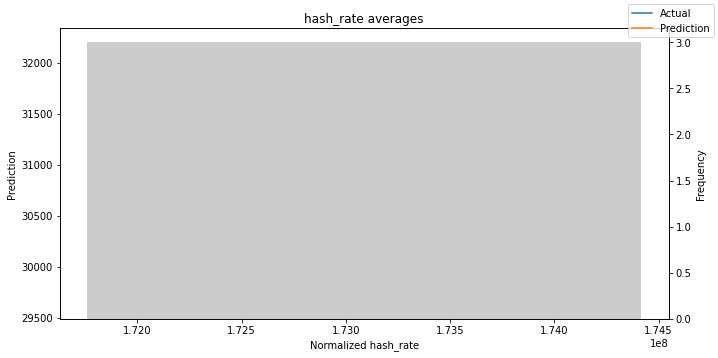

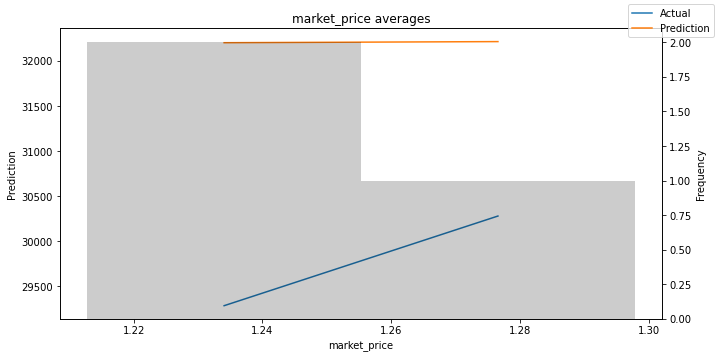

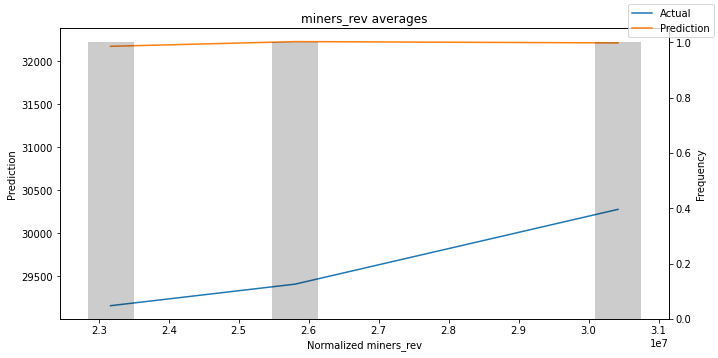

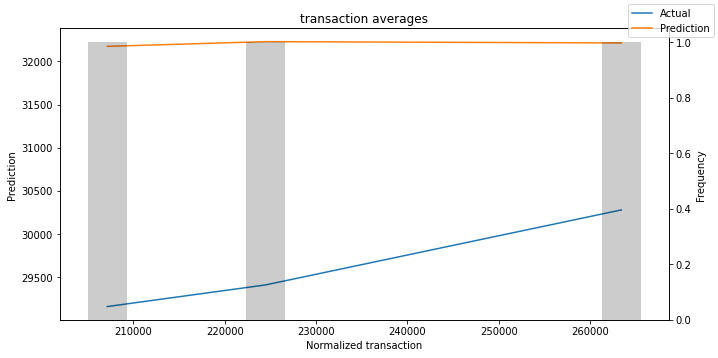

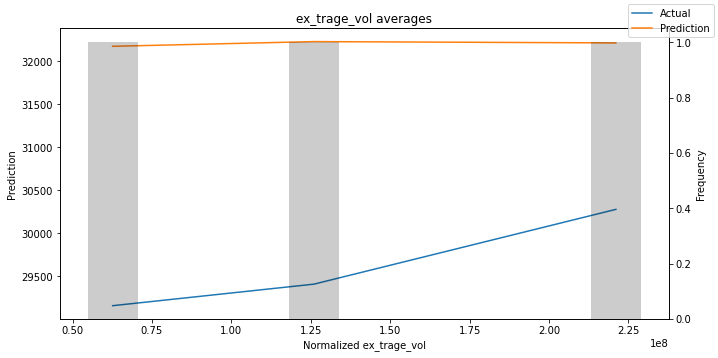

In [35]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
ave_loss = (actuals - predictions).abs().mean()
print(ave_loss)

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
#for idx in range(10):  # plot 10 examples

predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [12]:
# create the dataset from the pandas dataframe
# pre = 6, encoder = 30, cutoff-120 : error out of idx size
max_prediction_length = 5
max_encoder_length = 30
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    group_ids=["group"],
    target="market_price",
    time_idx="time_idx",
    add_relative_time_idx=True, # without this item, the error will occur in lr_find
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['ave_block_size', 'difficulty', 'hash_rate', 'market_price','miners_rev', 'transaction', 'ex_trage_vol']
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [13]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

842.849609375

In [14]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    default_root_dir = path
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /userhome/34/ybyan/pytorchForecasting/.lr_find_4d48b75a-3035-40be-abd7-d11d0ac7bc4e.ckpt


suggested learning rate: 4.073802778041128e-05


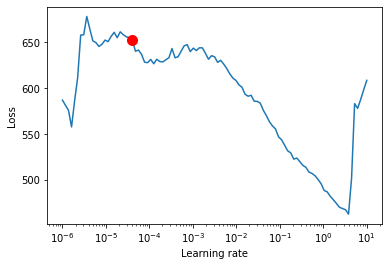

In [15]:
#print(trainer)
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [16]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(path + "/lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    enable_model_summary=False,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 4.073802778041128e-05,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.6k


In [17]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path=path + "/optuna_test",
    log_dir = path + '/lightning_logs',
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

import pickle
# save study results - also we can resume tuning at a later point in time
with open(path + "/test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-27 14:37:13,511] A new study created in memory with name: no-name-037009e8-8c46-49db-87fe-6d30af9c5f1f
/userhome/34/ybyan/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-05-27 14:41:51,417] Trial 0 finished with value: 320.00970458984375 and parameters: {'gradient_clip_val': 0.04052536593192359, 'hidden_size': 14, 'dropout': 0.10952221511300227, 'hidden_continuous_size': 13, 'attention_head_size': 2, 'learning_rate': 0.002099546382186867}. Best is trial 0 with value: 320.00970458984375.
/userhome/34/ybyan/anaconda3/lib/python3.8/si

{'gradient_clip_val': 0.17641866409874832, 'hidden_size': 126, 'dropout': 0.29821246344214214, 'hidden_continuous_size': 96, 'attention_head_size': 4, 'learning_rate': 0.01301643143264376}


/userhome/34/ybyan/pytorchForecasting/lightning_logs/lightning_logs/version_9/checkpoints/epoch=29-step=900.ckpt
tensor(7279.5273)


{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'market_price_center': <Figure size 720x360 with 2 Axes>,
 'market_price_scale': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'ave_block_size': <Figure size 720x360 with 2 Axes>,
 'difficulty': <Figure size 720x360 with 2 Axes>,
 'hash_rate': <Figure size 720x360 with 2 Axes>,
 'market_price': <Figure size 720x360 with 2 Axes>,
 'miners_rev': <Figure size 720x360 with 2 Axes>,
 'transaction': <Figure size 720x360 with 2 Axes>,
 'ex_trage_vol': <Figure size 720x360 with 2 Axes>}

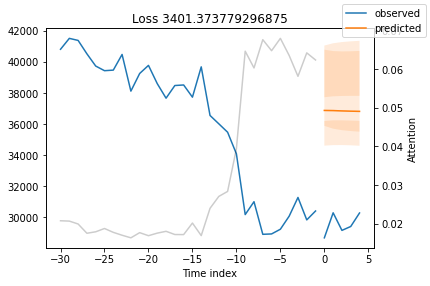

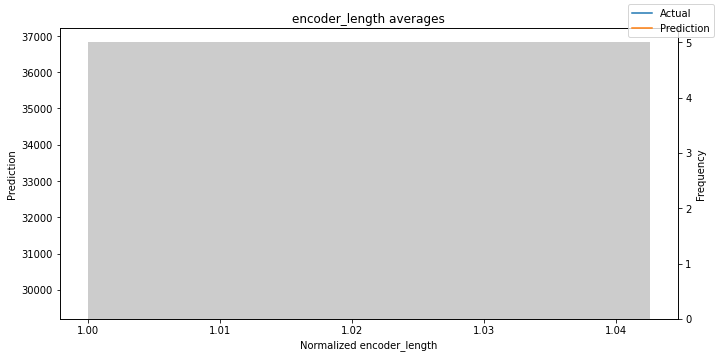

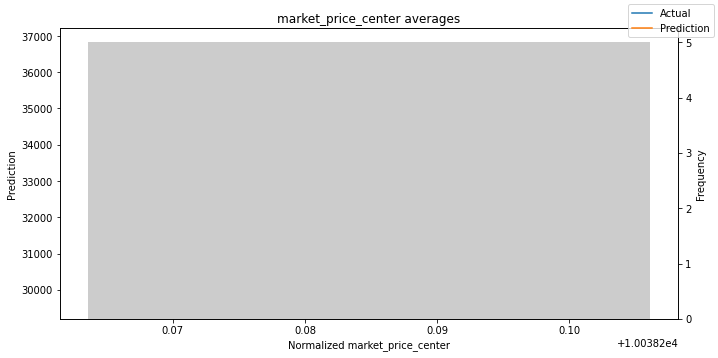

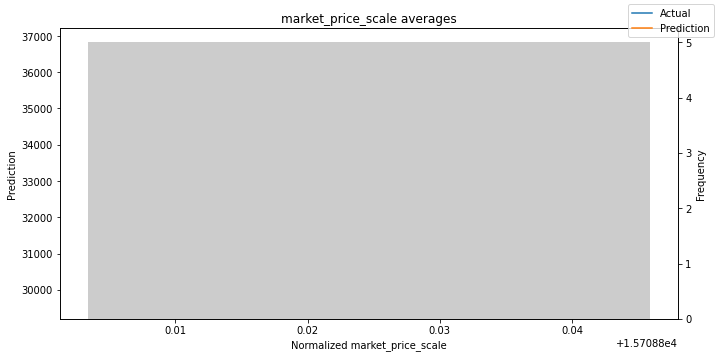

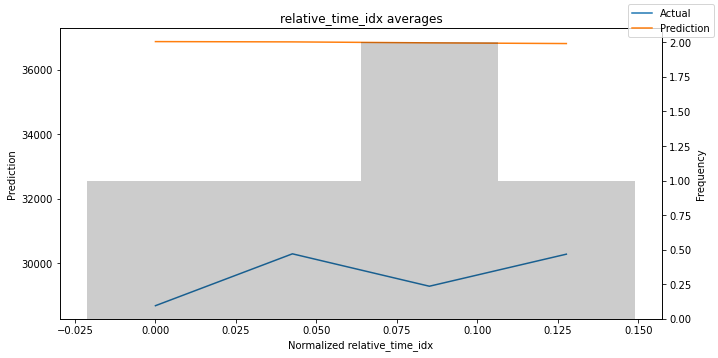

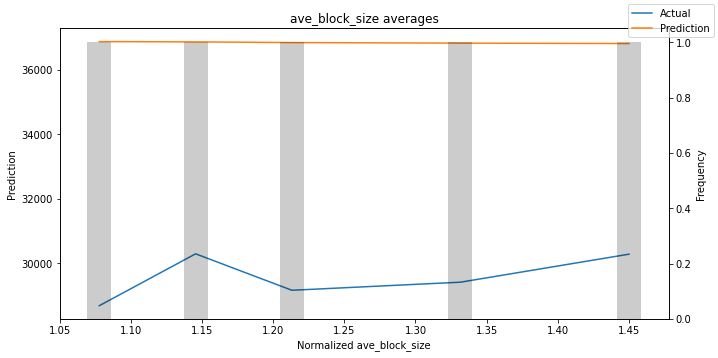

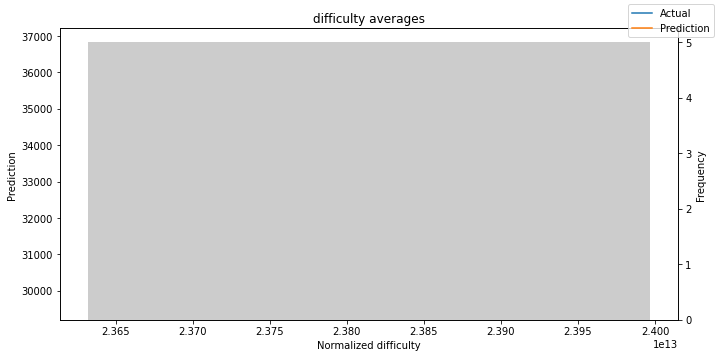

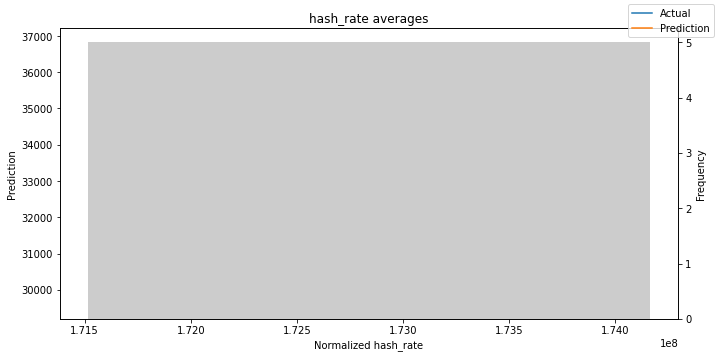

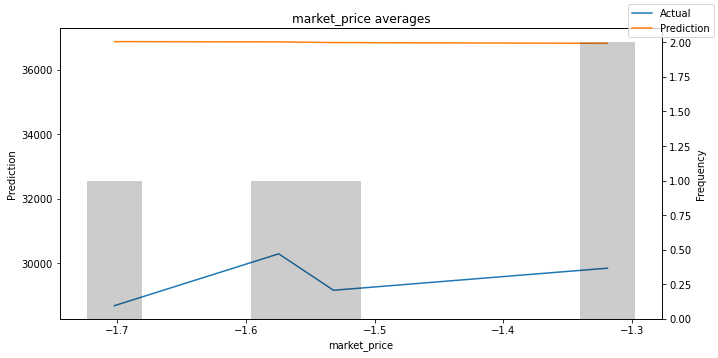

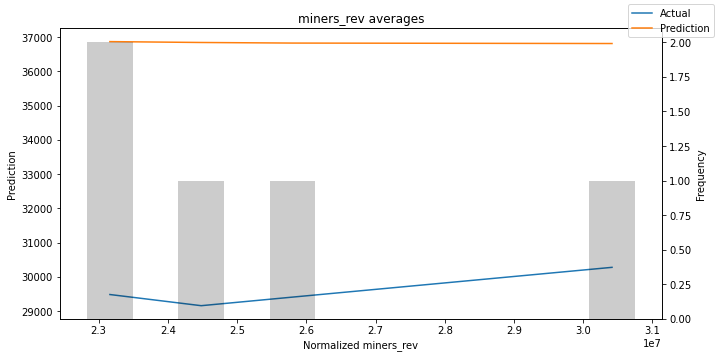

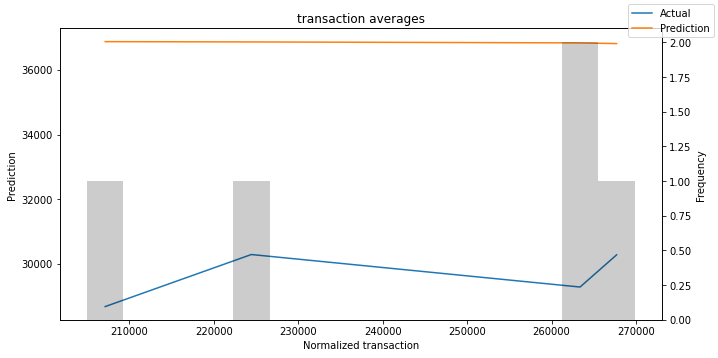

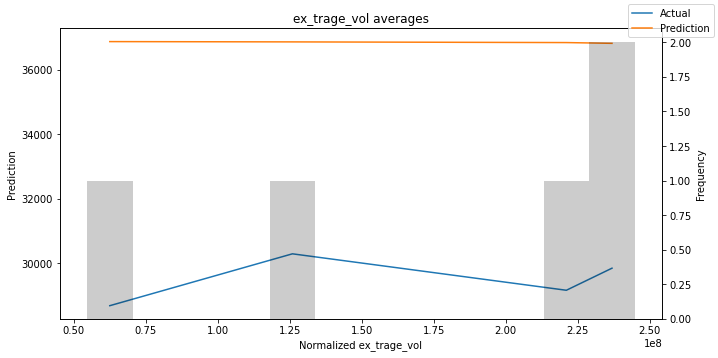

In [19]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
ave_loss = (actuals - predictions).abs().mean()
print(ave_loss)

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
#for idx in range(10):  # plot 10 examples

predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)